<a href="https://colab.research.google.com/github/francesco-source/DeepLearning/blob/main/image_inpainting/Encoder_denoiser_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise for image inpainting

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X


masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

170498071/170498071 [==============================] - 5s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


In [9]:

def display_history(history):
    mse_training = history.history['loss']

    mse_val = history.history['val_loss']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training/validation')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Model 1 
Searching around I found an interesting paper
 on a Gaussian noise removal from both grayscale and color images, so I tried to implement a network following the paper proposed network.
 The architecture is basically devided in 3 parts.
 
1. Classifier, a CNN classifier, not for classifing, but for extracting discriminative images features, that are used the the second part
2. Denoiser, it explicity removes the noise from image features learned in the first part.
3. Decoder, it is needed to map back the denoised image features into the image pixels.

In [ ]:
class FirstModel(tf.keras.Model):
  def __init__(self):
    super(FirstModel,self).__init__()
    #Classfier
    self.conv1 = tf.keras.layers.Conv2D(96,(3,3),padding = "same",activation = "relu")
    self.conv2 = tf.keras.layers.Conv2D(64,(3,3),padding = "same", activation = "relu")
    self.conv3 = tf.keras.layers.Conv2D(64,(5,5),padding = "same",activation = "relu")

    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv4 = tf.keras.layers.Conv2D(190,(3,3),padding = "same", activation = "relu")

    self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size = (2,2))

    # Denoiser 

    self.conv5 = tf.keras.layers.Conv2D(190,(3,3), padding = "same", activation = "relu")
    self.conv6 = tf.keras.layers.Conv2D(190,(3,3),padding = "same", activation = "sigmoid")

    #Decoder 
    self.conv7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')

    self.conv8 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
    self.conv9 = tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu')

    self.conv10 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
    self.conv11 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')

    self.upsample1 = tf.keras.layers.UpSampling2D((2, 2))

    self.conv12 = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')

  def call(self,inputs):

    output1 = self.conv1(inputs)

    output2 = self.conv2(output1)
    output3 = self.conv3(output2)

    output4 = tf.keras.layers.concatenate([output2, output3])
    output4 = self.bn1(output4)
    output4 = self.conv4(output4)
    output4 = self.maxpool1(output4)
    output4 = self.conv5(output4)
    output4 = self.conv6(output4)
    output4 = self.conv7(output4)

    output5 = self.conv8(output4)
    output6 = self.conv9(output4)

    output7 = tf.keras.layers.concatenate([output5, output6])
    output7 = self.conv10(output7)
    output7 = self.conv11(output7)
    output7 = self.upsample1(output7)
    output7 = self.conv12(output7)

    return output7


first_model = FirstModel()
first_model.build(input_shape=(None, 32, 32, 3))
first_model.summary()

I used the Adam optimizers with learning rate 0.0001, and the MSE as loss because we want to minimize that.

The validation split is set to 0.1, so the 10% of the train dataset is the validation datset, the epochs are 10, with an earlystopping in order to avoid overfitting.

In [6]:
first_model_callback = tf.keras.callbacks.EarlyStopping(patience = 3)

first_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.MSE)

first_history = first_model.fit(masked_x_train, x_train,  validation_split=0.1, epochs=5 ,batch_size=100,  callbacks=[first_model_callback])

Epoch 1/20
450/450 [==============================] - 60s 115ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 2/20
450/450 [==============================] - 51s 114ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 3/20
450/450 [==============================] - 51s 114ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 4/20
450/450 [==============================] - 52s 116ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 5/20
450/450 [==============================] - 52s 115ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 6/20
450/450 [==============================] - 52s 115ms/step - loss: 0.0073 - val_loss: 0.0083


In [8]:
eval_output = first_model.evaluate(masked_x_test, x_test, return_dict=True)

313/313 [==============================] - 5s 15ms/step - loss: 0.0084


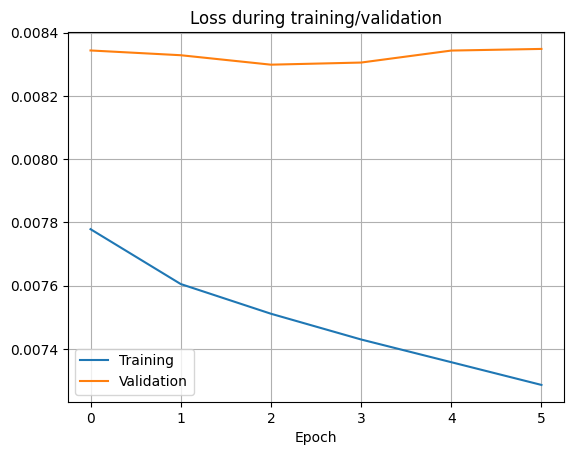

In [10]:
display_history(first_history)